In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
import os
import pathlib
import tensorflow as tf
data_dir='/content/drive/MyDrive/1_Project/500'
img_height =img_width=224

train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32) #32

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

normalization_layer = tf.keras.layers.Rescaling(1./255)

import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(300).prefetch(buffer_size=AUTOTUNE) #1000
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

NotFoundError: Could not find directory /content/drive/MyDrive/1_Project/500

In [ ]:
model = Sequential()
mod=SqueezeNet(include_top=False, weights='imagenet',input_shape=(image_height, image_width, channels))
#out_1=mod.layers[-5]


#adding global pooling layer to decrease dimension
gbl=GlobalAveragePooling2D()(mod.output)
model = Sequential()
model.add(Dense(32, input_shape=(16,)))
out=Dense(1,activation='sigmoid')(gbl)
model=Model(inputs=mod.input,outputs=out)

model.compile(optimizer=Adam(3e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
#learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


callbacks_list = [early]



n_training_samples = len(train)
n_validation_samples = len(valid)
n_test_samples=len(test)
validationsteps=n_validation_samples/32





epoch=30
#loop through each fold
#for index in tqdm(range(1,6)):


#set all layers to non trainable


#learning rate schedular

#fitting the model
#timing
hist=model.fit_generator(train,steps_per_epoch=n_training_samples//32,epochs=epoch,validation_data=valid,validation_steps=validationsteps
                      , callbacks=callbacks_list
                          )


NameError: ignored

In [ ]:
from tensorflow.python.keras.models import load_model
model.save('/content/drive/MyDrive/final_squeezenet.h5')
'''model.save('/content/drive/MyDrive/squeezenet')
model = load_model('/content/drive/MyDrive/squeezenet.h5')'''

In [ ]:
n_test_samples=len(test)
predict=model.predict_generator(test,steps=n_test_samples)
print(np.shape(predict))
submission_labels = np.argmax(predict, axis=1)

print(submission_labels.round())
print(np.shape(submission_labels))


(624,)


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

score, acc = model.evaluate_generator(test,steps=test.samples//32
                            )
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.5301896819942876
Test accuracy: 0.7549342


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print('f1 score ',f1_score(submission_labels.round(),test.classes,average='micro'))
print('accuracy ',accuracy_score(submission_labels.round(),test.classes))
print('recall ',recall_score(submission_labels.round(),test.classes,average=None))
print('precision ',precision_score(submission_labels.round(),test.classes,average=None))

f1 score  0.7596153846153846
accuracy  0.7596153846153846
recall  [0.91176471 0.72988506]
precision  [0.3974359  0.97692308]


AUC Value  :  0.6871794871794872


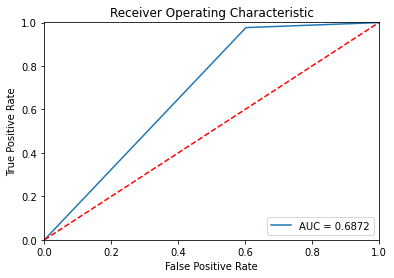

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fprValue2, tprValue2, thresholdsValue2 = roc_curve(test.classes,submission_labels.round())
AUCValue = auc(fprValue2, tprValue2)
print('AUC Value  : ', AUCValue)
plt.title('Receiver Operating Characteristic')
plt.plot(fprValue2, tprValue2, label='AUC = %0.4f'% AUCValue)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

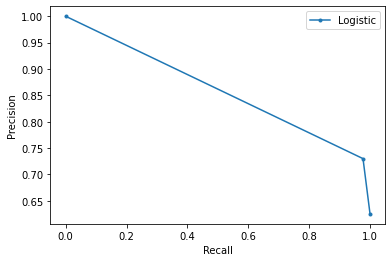

In [ ]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
precision, recall, _ = precision_recall_curve(test.classes, submission_labels.round())
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

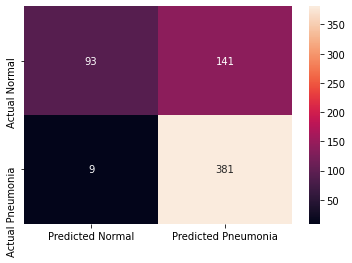

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
cm = pd.DataFrame(data=confusion_matrix(test.classes, submission_labels.round()),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
# Focal Loss function (helps with imbalanced classes)
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Clip predictions to avoid NaN errors
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

# Load dataset (Replace this with actual dataset loading)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

N = len(np.unique(y_train))
# **Multi-Class Classification for the entire task**
# The target is multi-class classification where:
# Class 0: Healthy, Classes 1-N: Diseases
# This assumes your labels are already integer-encoded, if not convert them accordingly.
y_train = np.where(y_train == 4, N, y_train)  # Mark healthy plants as class 0
y_val = np.where(y_val == 4, N, y_val)
y_test = np.where(y_test == 4, N, y_test)

# **Convert the labels to one-hot encoding**
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# **Define HyperModel for single-stage multi-class classification**
class MultiClassHyperModel(HyperModel):
    def build(self, hp):
        base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        base_model.trainable = False  # Freeze base model

        model = Sequential([base_model, Flatten()])

        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(Dense(hp.Int(f'units_{i}', 128, 512, 128), activation='relu', kernel_regularizer=l2(hp.Choice('l2_reg', [0.001, 0.01, 0.1]))))
            if hp.Boolean(f'batch_norm_{i}'):
                model.add(BatchNormalization())
            model.add(Dropout(hp.Float(f'dropout_{i}', 0.3, 0.5, step=0.1)))

        # Output layer for multi-class classification (one per class)
        model.add(Dense(y_train.shape[1], activation='softmax'))  # Multi-class classification output layer

        # Optimizer selection and learning rate tuning
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd', 'nadam', 'adagrad', 'adadelta', 'ftrl'])
        learning_rate = hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')

        if optimizer == 'adam':
            optimizer_instance = Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            optimizer_instance = RMSprop(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            momentum = hp.Float('momentum', 0.5, 0.9)
            optimizer_instance = SGD(learning_rate=learning_rate, momentum=momentum)
        elif optimizer == 'nadam':
            optimizer_instance = Nadam(learning_rate=learning_rate)
        elif optimizer == 'adagrad':
            optimizer_instance = Adagrad(learning_rate=learning_rate)
        elif optimizer == 'adadelta':
            optimizer_instance = Adadelta(learning_rate=learning_rate)
        elif optimizer == 'ftrl':
            optimizer_instance = Ftrl(learning_rate=learning_rate)

        # Compile the model
        model.compile(optimizer=optimizer_instance,
                      loss=focal_loss(gamma=2., alpha=0.25),  # Focal loss for imbalanced classes
                      metrics=['accuracy', Precision(), Recall()])
        return model

# **Hyperparameter tuning for the multi-class model**
tuner = BayesianOptimization(
    MultiClassHyperModel(),
    objective=Objective("val_recall", direction="max"),  # Maximize recall
    max_trials=1,
    executions_per_trial=1,
    overwrite=True
)

# Early stopping and learning rate reduction on plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_multiclass_model.h5", monitor="val_recall", save_best_only=True, mode="max")
]

# Perform the search for best hyperparameters
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32, callbacks=callbacks, verbose=1)

# Get the best hyperparameters and rebuild the model manually
best_hps = tuner.get_best_hyperparameters()[0]
best_model = MultiClassHyperModel().build(best_hps)

# **Train the model**
best_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32, callbacks=callbacks)

# **Evaluate the model**
print("\nTRAIN - Plant Disease Classification (Multi-Class)")
best_model.evaluate(X_train, y_train)

print("\nTEST - Plant Disease Classification (Multi-Class)")
best_model.evaluate(X_test, y_test)

In [ ]:
## IMPORTING LIBRARIES
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
# import mahotas  # For NGTDM feature extraction
import pickle
import tensorflow as tf

from PIL import Image
from google.colab import drive
from tqdm import tqdm
from skimage.filters import threshold_otsu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, average_precision_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.preprocessing import label_binarize, StandardScaler
from skimage.feature import graycomatrix, graycoprops  # For GLCM functions
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras.preprocessing import image_dataset_from_directory
from collections import Counter




from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras_tuner import HyperModel, BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.utils.class_weight import compute_class_weight

# Import necessary libraries
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam, Adagrad, Adadelta, Ftrl
from tensorflow.keras import backend as K

from keras.utils import to_categorical